# Lambda-Adaptive TD($\lambda$)
_
**Author:** Daniel Mastropietro  
**Date:** 19-Apr-2020
_

## Analysis of TD($\lambda$) and $\lambda$-return (here called MC($\lambda$)) on a 1D gridworld

A 1D gridworld with 21 states is considered, having the leftmost and rightmost states as terminal states giving respectively rewards -1.0 and +1.0 when attained.

The agent follows the random walk policy and its goal is to **estimate the state value function**.

Three different learners are considered:
- TD($\lambda$)
- $\lambda$-return (here called MC($\lambda$))
- $\lambda$-adaptive TD (new proposal), where $\lambda$ is allowed to vary at each time step, as a measure of the magnitude of the temporal gradient of the observed return.

**The goals of this exercise are:**  
1) Test an RL-framework that was created as a factory of policies and learners to be applied to different environments.  
2) To confirm that the implementation of the algorithms work on a very simple example.  
3) To get a feeling of the performance of an $\lambda$-adaptive TD algorithm.

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt, cm    # cm is for colormaps (e.g. cm.get_cmap())

import runpy
runpy.run_path("../setup.py")

#from Python.lib import environments, agents
from Python.lib.environments import Environment
from Python.lib.agents import GeneralAgent

from Python.lib.environments import gridworlds
from Python.lib.agents.policies import random_walks
from Python.lib.agents.learners import mc
from Python.lib.agents.learners import td

from Python.lib.simulators import Simulator

%matplotlib inline

Directory:
E:\Daniel\Projects\PhD-RL-Toulouse\projects
has been prepended to the module search path.


### Plotting functions

In [2]:
def plot_rmse_by_episode(rmse_mean_values, rmse_se_values=None, max_rmse=None, color="black", hold=False):
    """
    Plots the average RMSE values (over states) by episode
    
    @param rmse_mean_values: numpy array containing the average RMSE value per episode.
    @param rmse_se_values: (optional) numpy array containing an error measure of the average RMSE, e.g. their standard error.
    @param max_mse: (optional) maximum RMSE value to show in the plot (for visual comparison reasons)
    """

    nepisodes = len(rmse_mean_values)
    if max_rmse is None:
        max_rmse = np.max(rmse_mean_values)*1.1

    if not hold:
        plt.figure(figsize=(10,10))
    ax = plt.gca()
    ax.plot(np.arange(nepisodes)+1, rmse_mean_values, color=color)
    if rmse_se_values is not None:
        ax.errorbar(np.arange(nepisodes)+1, rmse_mean_values, yerr=rmse_se_values, capsize=4, color=color)
    ax.set_xticks(np.arange(nepisodes)+1)
    ax.set_ylim((0, max_rmse))
    ax.set_xlabel("Episode")
    ax.set_ylabel("RMSE")    
    ax.set_title("Average RMSE by episode")

### Simulation functions

In [3]:
def simulate(env, policy, learner,
             seed=None, nexperiments=10, nepisodes=20, start=None,
             alphas=[0.2], lambdas=[0.9], gamma=0.8,
             plot=True, max_alpha=1, max_rmse=0.5, error_bars=True,
             verbose=True, debug=False, show_warnings=True):
    "Simulates an environment using the given policy and learner"

    # Remove overflow warnings that happen when lambda and/or alpha are too large...    
    import warnings
    if show_warnings:
        warnings.filterwarnings("once")
    else:
        warnings.filterwarnings("ignore")

    learner_module = learner.__module__.upper()
    learner_name = learner_module[ learner_module.rfind(".")+1:]

    # Plotting setup
    if plot:
        colormap = cm.get_cmap("jet")
        fig = plt.figure(figsize=(20, 10))
        #(ax_full, ax_scaled, ax_rmse_by_episode) = fig.subplots(1,3)
        (ax_full, ax_scaled) = fig.subplots(1,2)

    n_lambdas = len(lambdas)
    n_alphas = len(alphas)
    n_simul = n_lambdas*n_alphas

    # List of dictionaries, each containing the characteristic of each parameterization considered
    df_results = pd.DataFrame(data=np.nan*np.zeros((n_simul, 5)), columns=['idx_lambda', 'lambda', 'alpha', 'rmse_mean', 'rmse_se'])
    legend_label = []
    # Average RMSE obtained at the LAST episode run for each parameter set and their standard error
    rmse_mean_values = np.nan*np.zeros((n_lambdas, n_alphas))
    rmse_se_values = np.nan*np.zeros((n_lambdas, n_alphas))
    # Average RMSE over the episodes run for each parameter set and their standard error 
    rmse_episodes_mean = np.nan*np.zeros((n_lambdas, n_alphas))
    rmse_episodes_se = np.nan*np.zeros((n_lambdas, n_alphas))
    # RMSE over the episodes averaged over ALL parameter set runs with their standard error
    rmse_episodes_mean_values = np.zeros(nepisodes)
    rmse_episodes_se2_values = np.zeros(nepisodes)
    idx_simul = -1
    for idx_lmbda, lmbda in enumerate(lambdas):
        rmse_mean_lambda = []
        rmse_se_lambda = []
        rmse_episodes_mean_lambda = []
        rmse_episodes_se_lambda = []
        for alpha in alphas:
            idx_simul += 1
            if verbose:
                print("Parameter set {} of {}: lambda = {:.2f}, alpha = {:.2f} --->" \
                      .format(idx_simul+1, n_simul, lmbda, alpha), end=" ")
            learner.setParams(alpha=alpha, gamma=gamma, lmbda=lmbda)
            learner.reset(reset_episode=True, reset_value_functions=True)
            agent = GeneralAgent(pol_rw,
                                 learner)
            # NOTE: Setting the seed here implies that each set of experiments
            # (i.e. for each combination of alpha and lambda) yields the same outcome in terms
            # of visited states and actions.
            # This is DESIRED --as opposed of having different state-action outcomes for different
            # (alpha, lambda) settings-- as it better isolates the effect of alpha and lambda.
            # VERIFIED BY RUNNING IN DEBUG MODE!
            sim = Simulator(env, agent, seed=seed, debug=debug)

            # Run the simulation and store the results
            rmse_mean, rmse_se, rmse_episodes_mean_idx, rmse_episodes_se_idx = \
                                                sim.simulate(nexperiments=nexperiments,
                                                             nepisodes=nepisodes,
                                                             start=start,
                                                             verbose=False)
            df_results.loc[idx_simul] = [idx_lmbda, lmbda, alpha, rmse_mean, rmse_se]
            rmse_mean_lambda += [rmse_mean]
            rmse_se_lambda += [rmse_se]
            # Average RMSE over all the episodes (this is what is reported by Sutton in their graphs in Chapter 12)
            # (not the best measure to report according to me... we should just look at the RMSE once the LAST episode is run
            # since the agent learns more after every episode!)
            rmse_episodes_mean_lambda += [np.mean(rmse_episodes_mean_idx)]
            rmse_episodes_se_lambda += [np.std(rmse_episodes_mean_idx) / np.sqrt(nepisodes)]
            # Average RMSE by episode and their standard error
            rmse_episodes_mean_values += rmse_episodes_mean_idx
            rmse_episodes_se2_values += rmse_episodes_se_idx**2

            if verbose:
                print("\tRMSE = {:.3g} ({:.3g})".format(rmse_mean, rmse_se))

        # Store the RMSE results for the current lambda
        rmse_mean_values[idx_lmbda] = np.array(rmse_mean_lambda)
        rmse_se_values[idx_lmbda] = np.array(rmse_se_lambda)
        rmse_episodes_mean[idx_lmbda] = np.array(rmse_episodes_mean_lambda)
        rmse_episodes_se[idx_lmbda] = np.array(rmse_episodes_se_lambda)

        if plot:
            # Plot the average RMSE for the current lambda as a function of alpha
            #rmse2plot = rmse_mean_lambda
            #rmse2plot_error = rmse_se_lambda
            #ylabel = "Average RMSE over all {} states, at the end of episode {}, averaged over {} experiments".format(env.getNumStates(), nepisodes, nexperiments)
            rmse2plot = rmse_episodes_mean_lambda
            rmse2plot_error = rmse_episodes_se_lambda
            ylabel = "Average RMSE over all {} states, first {} episodes, and {} experiments".format(env.getNumStates(), nepisodes, nexperiments)

            # Map blue to the largest lambda and red to the smallest lambda (most similar to the color scheme used in Sutton, pag. 295)
            color = colormap( 1 - idx_lmbda / np.max((1, n_lambdas-1)) )
            ax_full.plot(alphas, rmse2plot, '.-', color=color)
            if error_bars:
                ax_full.errorbar(alphas, rmse2plot, yerr=rmse2plot_error, capsize=4, color=color)
            ax_full.set_title("Error measure for different (lambda, alpha) (FULL scale)")
            ax_full.set_xlabel("alpha")
            ax_full.set_ylabel(ylabel)
            legend_label += ["lam={:.2g}".format(lmbda)]

    # Average RMSE by episode for rate of convergence analysis
    rmse_episodes_mean_overall = rmse_episodes_mean_values / n_simul
    rmse_episodes_se_overall = np.sqrt(rmse_episodes_se2_values) / n_simul  # This is sqrt( sum(SE^2) ) / n_simul, based on calculations done on paper on 19-Apr-2020

    # Scaled plot (for comparison purposes)
    if plot:
        for idx_lmbda, lmbda in enumerate(lambdas):
            #rmse2plot = rmse_mean_values[idx_lmbda]
            #rmse2plot_error = rmse_se_values[idx_lmbda]
            rmse2plot = rmse_episodes_mean[idx_lmbda]
            rmse2plot_error = rmse_episodes_se[idx_lmbda]
            color = colormap( 1 - idx_lmbda / np.max((1, n_lambdas-1)) )
            ax_scaled.plot(alphas, rmse2plot, '.-', color=color)
            if error_bars:
                ax_scaled.errorbar(alphas, rmse2plot, yerr=rmse2plot_error, capsize=4, color=color)
            ax_scaled.set_title("Error measure for different (lambda, alpha) (ZOOMED for visual comparison)")
            ax_scaled.set_xlabel("alpha")
            ax_scaled.set_xlim((0, max_alpha))
            ax_scaled.set_ylim((0, max_rmse))

        plt.figlegend(legend_label)
        fig.suptitle("{}(lambda): gamma = {:.2g}, #experiments = {}, #episodes = {}"\
                     .format(learner_name, gamma, nexperiments, nepisodes), fontsize=18)

    # Restore warnings default
    warnings.filterwarnings("default")

    return df_results, pd.DataFrame({'episode': np.arange(nepisodes) + 1, 'rmse_mean': rmse_episodes_mean_overall, 'rmse_se': rmse_episodes_se_overall}) 

In [4]:
# The environment
env = gridworlds.EnvGridworld1D(length=21)

# Possible policies and learners for agents
pol_rw = random_walks.PolRandomWalkDiscrete(env)
lea_td = td.LeaTDLambda(env)
lea_td_adap = td.LeaTDLambdaAdaptive(env)
lea_mc = mc.LeaMCLambda(env)

#-- Define hyperparameter values
gamma = 1  # Undiscounted task, as stated in Example 6.2, Sutton, pag. 125 when they present the 5-step 1D random walk extended later on to 19-step random walk
# Grid values
n_lambdas = 10
n_alphas = 8
lambdas_grid = np.linspace(0, 1, n_lambdas)
alphas_grid = np.linspace(0.1, 0.7, n_alphas)
# Ad-hoc values
lambdas_adhoc_mc = [0, 0.4, 0.8, 0.9, 0.95, 0.99, 1]
alphas_adhoc_mc = [0.01] + list(np.linspace(0.1, 1.2, 10))
lambdas_adhoc_td = [0, 0.4, 0.8, 0.9, 0.95, 0.99, 1]
alphas_adhoc_td = [0.01] + list(np.linspace(0.1, 0.9, 10))

### 1) TD($\lambda$), $\gamma = 1$, #Experiments = 1, Performance Measure: Average RMSE over first 10 episodes

    idx_lambda  lambda     alpha      rmse_mean  rmse_se
0          0.0    0.00  0.010000   4.884636e-01      NaN
1          0.0    0.00  0.100000   2.530513e-01      NaN
2          0.0    0.00  0.188889   1.083803e-01      NaN
3          0.0    0.00  0.277778   1.026142e-01      NaN
4          0.0    0.00  0.366667   1.777862e-01      NaN
5          0.0    0.00  0.455556   2.511554e-01      NaN
6          0.0    0.00  0.544444   3.123861e-01      NaN
7          0.0    0.00  0.633333   3.548593e-01      NaN
8          0.0    0.00  0.722222   3.717878e-01      NaN
9          0.0    0.00  0.811111   3.618509e-01      NaN
10         0.0    0.00  0.900000   3.717198e-01      NaN
11         1.0    0.40  0.010000   5.081470e-01      NaN
12         1.0    0.40  0.100000   4.079539e-01      NaN
13         1.0    0.40  0.188889   3.252654e-01      NaN
14         1.0    0.40  0.277778   2.535974e-01      NaN
15         1.0    0.40  0.366667   1.919915e-01      NaN
16         1.0    0.40  0.45555

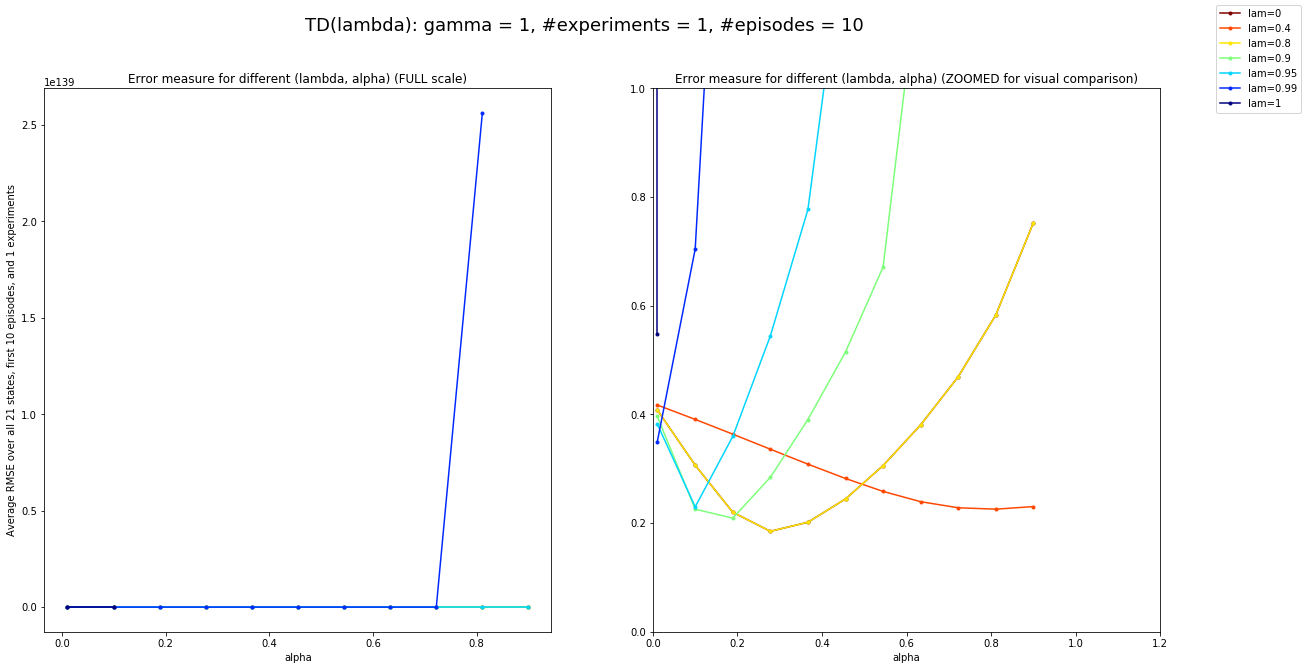

In [17]:
# Simulation parameters
seed = 1713
nexperiments = 1
nepisodes = 10

df_results_td, df_rmse_by_episode_td = simulate(env, pol_rw, lea_td,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=alphas_adhoc_td, lambdas=lambdas_adhoc_td, gamma=gamma,
                         max_alpha=np.max(alphas_adhoc_mc), max_rmse=1, error_bars=False,
                         verbose=False, debug=False, show_warnings=False)
print(df_results_td)

The RMSE diverges very "quickly" for smaller and smaller $\alpha$'s as $\lambda$ gets larger.

### 2) MC($\lambda$), $\gamma = 1$, #Experiments = 1, Performance Measure: Average RMSE over first 10 episodes

    idx_lambda  lambda     alpha  rmse_mean  rmse_se
0          0.0    0.00  0.010000   0.488671      NaN
1          0.0    0.00  0.100000   0.268356      NaN
2          0.0    0.00  0.222222   0.110043      NaN
3          0.0    0.00  0.344444   0.104530      NaN
4          0.0    0.00  0.466667   0.161709      NaN
5          0.0    0.00  0.588889   0.215152      NaN
6          0.0    0.00  0.711111   0.263650      NaN
7          0.0    0.00  0.833333   0.310781      NaN
8          0.0    0.00  0.955556   0.358526      NaN
9          0.0    0.00  1.077778   0.407728      NaN
10         0.0    0.00  1.200000   0.459317      NaN
11         1.0    0.40  0.010000   0.508160      NaN
12         1.0    0.40  0.100000   0.409809      NaN
13         1.0    0.40  0.222222   0.304258      NaN
14         1.0    0.40  0.344444   0.219607      NaN
15         1.0    0.40  0.466667   0.159410      NaN
16         1.0    0.40  0.588889   0.131980      NaN
17         1.0    0.40  0.711111   0.139088   

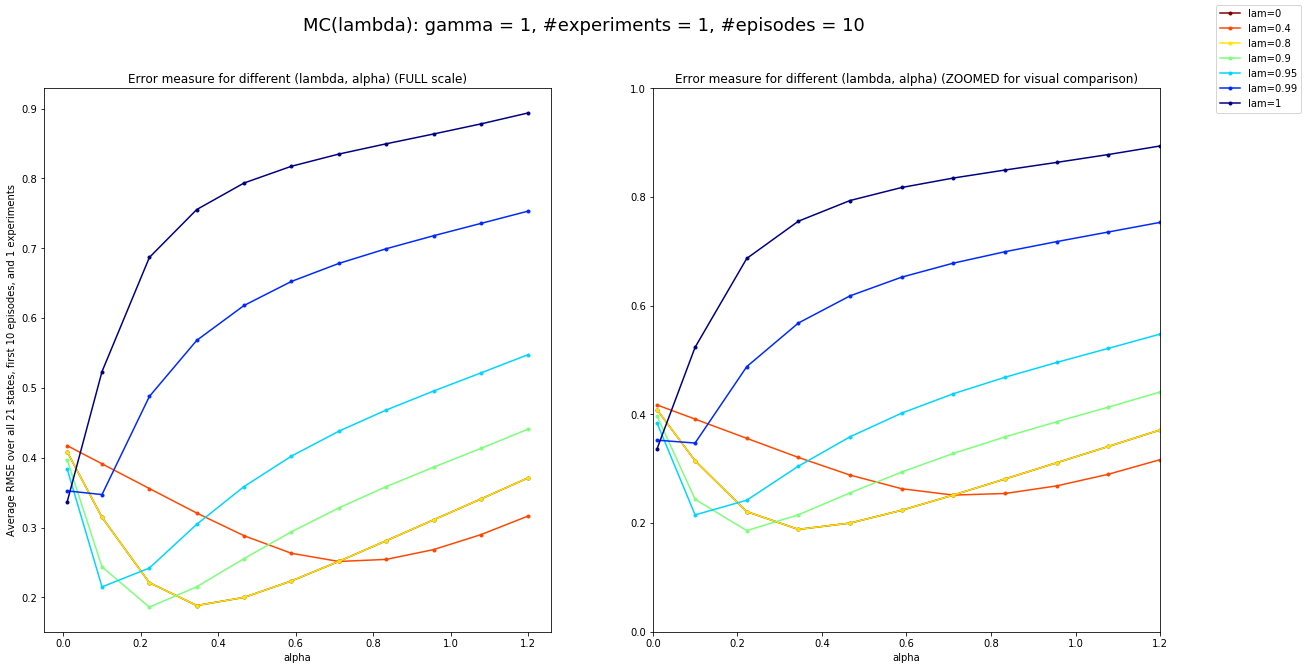

In [18]:
# Simulation setup
seed = 1713
nexperiments = 1
nepisodes = 10

df_results_mc, df_rmse_by_episode_mc = simulate(env, pol_rw, lea_mc,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=alphas_adhoc_mc, lambdas=lambdas_adhoc_mc, gamma=gamma,
                         max_alpha=np.max(alphas_adhoc_mc), max_rmse=1, error_bars=False,
                         verbose=False, debug=False, show_warnings=False)
print(df_results_mc)

The RMSE diverges much more slowly than the TD case as $\alpha$ increases beyond the optimum attained for each $\lambda$.

### 3) $\lambda$-adaptive TD, $\gamma = 1$, #Experiments = 1, Performance Measure: Average RMSE over first 10 episodes
This algorithm proposes to adapt $\lambda$ at each learning time step in the TD($\lambda$) algorithm by defining $\lambda$ as a function of the $\delta(t)$ TD error, i.e.:

$\delta(t) = R_{t+1} + \gamma V(S(t+1)) - V(S(t))$

where $V(s)$ is the estimated state value function for state $s$, and $S(t)$ is the state of the environment at time $t$.

The value of $\lambda$ is now allowed to change at each time step $t$ and is proposed as a sigmoid function of the $\delta(t)$ error *relative* to the estimated state value function at time $t$, namely:

$\lambda(t) = 1 - exp(- |\delta_{rel}(t)| )$

where $\delta_{rel}(t)$ is given by:

- $0$ if $V(S(t)) = 0$ and $\delta(t) = 0$
- $+\infty$ if $V(S(t)) = 0$ and $\delta(t) \neq 0$
- $\frac{\delta(t)}{V(S(t))}$ o.w.

Note that $\lambda(t) \to 0^+$ when $\delta_{rel}(t) \to 0$ and tends to 1 when $|\delta_{rel}(t)| \to +\infty$.

However, this adaptation is _not_ done for all time steps: in order to _accelerate_ the initial convergence of the algorithm for environments with only-terminal rewards, we use a fixed $\lambda$ for a time step as long as the _value function at the next time step has not been updated at least once_.

    idx_lambda  lambda     alpha  rmse_mean  rmse_se
0          0.0    0.00  0.010000   0.499261      NaN
1          0.0    0.00  0.100000   0.360194      NaN
2          0.0    0.00  0.188889   0.260791      NaN
3          0.0    0.00  0.277778   0.179049      NaN
4          0.0    0.00  0.366667   0.109847      NaN
5          0.0    0.00  0.455556   0.071760      NaN
6          0.0    0.00  0.544444   0.106306      NaN
7          0.0    0.00  0.633333   0.164587      NaN
8          0.0    0.00  0.722222   0.232172      NaN
9          0.0    0.00  0.811111   0.314301      NaN
10         0.0    0.00  0.900000   0.430506      NaN
11         1.0    0.40  0.010000   0.500872      NaN
12         1.0    0.40  0.100000   0.370844      NaN
13         1.0    0.40  0.188889   0.277347      NaN
14         1.0    0.40  0.277778   0.203684      NaN
15         1.0    0.40  0.366667   0.141481      NaN
16         1.0    0.40  0.455556   0.093930      NaN
17         1.0    0.40  0.544444   0.065404   

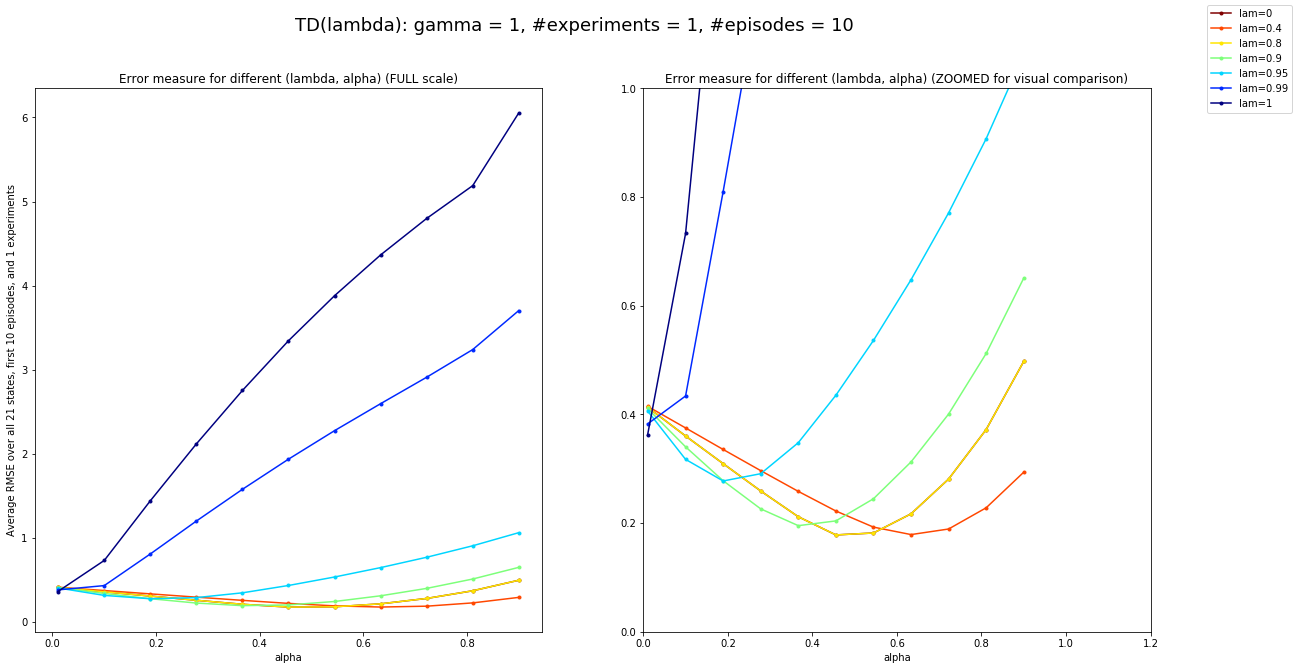

In [19]:
from importlib import reload
from Python.lib.agents.learners import td
reload(td)
from Python.lib.agents.learners import td
from Python.lib.agents.learners.td import LeaTDLambdaAdaptive
##from td import LeaTDLambdaAdaptive    # <-- Here I get the error that no module named 'td' exists... WHY??? (since reload(td) gives no error!!)

# Simulation parameters
seed = 1713
nexperiments = 1
nepisodes = 10

df_results_td, df_rmse_by_episodes_td_adap = simulate(env, pol_rw, lea_td_adap,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=alphas_adhoc_td, lambdas=lambdas_adhoc_td, gamma=gamma,
                         max_alpha=np.max(alphas_adhoc_mc), max_rmse=1, error_bars=False,
                         verbose=False, debug=False, show_warnings=False)
print(df_results_td)

In this case there is clearly **only one curve** since $\lambda$ is no longer a hyperparameter of the optimization problem.

### 4) Analysis of the rate of convergence
We now compare the evolution of the average RMSE (over all states and all experiments) among the three algorithms.

For each algorithm we choose the $\lambda$ and $\alpha$ parameters that correspond to the minimum RMSE from the above simulations, namely:

- TD($\lambda$): $\lambda = 0.8$, $\alpha = 0.3$  
- MC($\lambda$): $\lambda = 0.8$, $\alpha = 0.35$
- TD adaptive: $\alpha = 0.65$

We run 30 experiments with 10 episodes each.

In [28]:
# Simulation parameters
seed = 1713
nexperiments = 30
nepisodes = 10
# Optimum parameters for TD(lambda) and MC(lambda)
lambdas_opt = {'td': 0.8, 'mc': 0.8, 'td_adap': 0.8}
alphas_opt = {'td': 0.3, 'mc': 0.35, 'td_adap': 0.45}

df_results_td, df_rmse_by_episode_td = simulate(env, pol_rw, lea_td,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=[alphas_opt['td']], lambdas=[lambdas_opt['td']], gamma=gamma,
                         plot=False, verbose=False, debug=False, show_warnings=False)
print("RMSE by Episode for TD(lambda)")
print(df_rmse_by_episode_td)

df_results_mc, df_rmse_by_episode_mc = simulate(env, pol_rw, lea_td,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=[alphas_opt['mc']], lambdas=[lambdas_opt['mc']], gamma=gamma,
                         plot=False, verbose=False, debug=False, show_warnings=False)
print("RMSE by Episode for MC(lambda)")
print(df_rmse_by_episode_mc)

df_results_td_adap, df_rmse_by_episode_td_adap = simulate(env, pol_rw, lea_td_adap,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=[alphas_opt['td_adap']], lambdas=[lambdas_opt['td']], gamma=gamma,
                         plot=False, verbose=False, debug=False, show_warnings=False)
print("RMSE by Episode for TD(lambda) adaptive")
print(df_rmse_by_episode_td_adap)

RMSE by Episode for TD(lambda)
   episode  rmse_mean   rmse_se
0        1   0.384170  0.004731
1        2   0.330270  0.008780
2        3   0.289204  0.008284
3        4   0.255888  0.009819
4        5   0.228823  0.008888
5        6   0.195862  0.009894
6        7   0.175687  0.013070
7        8   0.167642  0.012707
8        9   0.153918  0.014366
9       10   0.161359  0.013616
RMSE by Episode for MC(lambda)
   episode  rmse_mean   rmse_se
0        1   0.378853  0.005416
1        2   0.319607  0.009934
2        3   0.276334  0.009637
3        4   0.243437  0.011479
4        5   0.221219  0.010863
5        6   0.193393  0.011302
6        7   0.180987  0.015554
7        8   0.179960  0.015021
8        9   0.173277  0.015853
9       10   0.188564  0.015095
RMSE by Episode for TD(lambda) adaptive
   episode  rmse_mean   rmse_se
0        1   0.361768  0.005162
1        2   0.316378  0.008765
2        3   0.281873  0.008702
3        4   0.248958  0.009084
4        5   0.219967  0.009690
5 

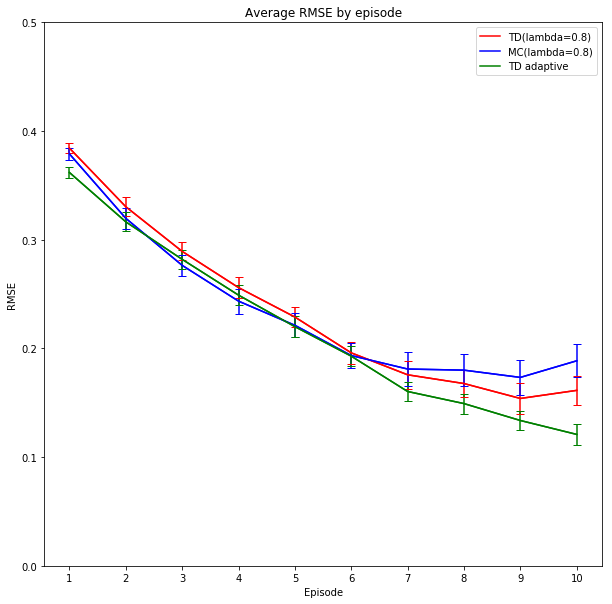

In [29]:
plot_rmse_by_episode(df_rmse_by_episode_td['rmse_mean'], df_rmse_by_episode_td['rmse_se'], color="red", max_rmse=0.5)
plot_rmse_by_episode(df_rmse_by_episode_mc['rmse_mean'], df_rmse_by_episode_mc['rmse_se'], color="blue", max_rmse=0.5, hold=True)
plot_rmse_by_episode(df_rmse_by_episode_td_adap['rmse_mean'], df_rmse_by_episode_td_adap['rmse_se'], color="green", max_rmse=0.5, hold=True)
plt.legend(['TD(lambda={:.1f})'.format(lambdas_opt['td']), 'MC(lambda={:.1f})'.format(lambdas_opt['mc']), 'TD adaptive'])

We observe that the RMSE in the $\lambda$-adaptive TD case decreases more slowly than the other two cases, but attains a smaller RMSE value at the end of the 10 episodes, with the important advantage that there is no need of defining hyperparameter $\lambda$.

In addition, the variability observed in the RMSE at each episode tends to be smaller.

#### What happens if we run each experiment for a longer number of episodes?

We now increase the number of episodes run per experiment from 10 to 50.

In [30]:
# Simulation parameters
seed = 1713
nexperiments = 30
nepisodes = 50

df_results_td, df_rmse_by_episode_td = simulate(env, pol_rw, lea_td,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=[alphas_opt['td']], lambdas=[lambdas_opt['td']], gamma=gamma,
                         plot=False, verbose=False, debug=False, show_warnings=False)
print("RMSE by Episode for TD(lambda)")
print(df_rmse_by_episode_td)

df_results_mc, df_rmse_by_episode_mc = simulate(env, pol_rw, lea_td,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=[alphas_opt['mc']], lambdas=[lambdas_opt['mc']], gamma=gamma,
                         plot=False, verbose=False, debug=False, show_warnings=False)
print("RMSE by Episode for MC(lambda)")
print(df_rmse_by_episode_mc)

df_results_td_adap, df_rmse_by_episode_td_adap = simulate(env, pol_rw, lea_td_adap,
                         seed=seed, nexperiments=nexperiments, nepisodes=nepisodes, start=None,
                         alphas=[alphas_opt['td_adap']], lambdas=[lambdas_opt['td']], gamma=gamma,
                         plot=False, verbose=False, debug=False, show_warnings=False)
print("RMSE by Episode for TD(lambda) adaptive")
print(df_rmse_by_episode_td_adap)

RMSE by Episode for TD(lambda)
    episode  rmse_mean   rmse_se
0         1   0.394202  0.005375
1         2   0.342531  0.009112
2         3   0.308349  0.009515
3         4   0.272187  0.009879
4         5   0.244059  0.010820
5         6   0.207592  0.014417
6         7   0.195408  0.016925
7         8   0.187581  0.014499
8         9   0.177545  0.014901
9        10   0.181723  0.015821
10       11   0.180205  0.013522
11       12   0.171619  0.015616
12       13   0.169464  0.016235
13       14   0.184650  0.016093
14       15   0.194763  0.017853
15       16   0.203168  0.017444
16       17   0.235724  0.018176
17       18   0.233584  0.019351
18       19   0.243450  0.016039
19       20   0.251998  0.015961
20       21   0.266619  0.020666
21       22   0.271543  0.021325
22       23   0.267939  0.023837
23       24   0.261703  0.019687
24       25   0.266391  0.019814
25       26   0.262495  0.020799
26       27   0.271081  0.020876
27       28   0.260245  0.018747
28       29 

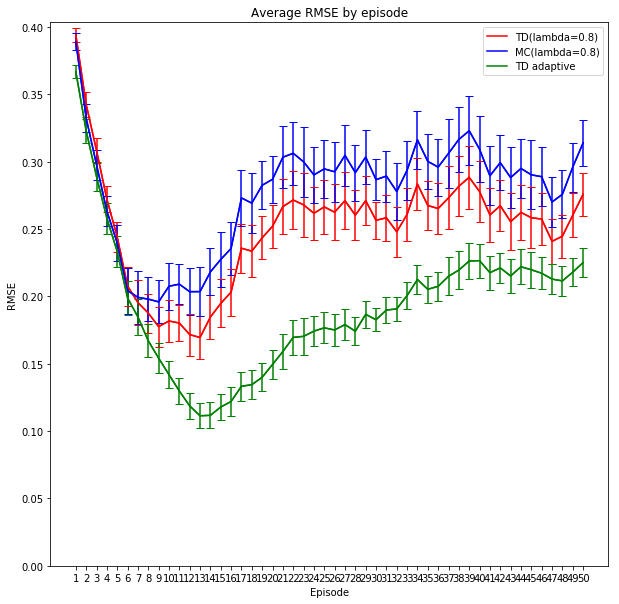

In [31]:
plot_rmse_by_episode(df_rmse_by_episode_td['rmse_mean'], df_rmse_by_episode_td['rmse_se'], color="red")
plot_rmse_by_episode(df_rmse_by_episode_mc['rmse_mean'], df_rmse_by_episode_mc['rmse_se'], color="blue", hold=True)
plot_rmse_by_episode(df_rmse_by_episode_td_adap['rmse_mean'], df_rmse_by_episode_td_adap['rmse_se'], color="green", hold=True)
plt.legend(['TD(lambda={:.1f})'.format(lambdas_opt['td']), 'MC(lambda={:.1f})'.format(lambdas_opt['mc']), 'TD adaptive'])

We observe that the RMSE starts increasing back in all cases, and that the $\lambda$-adaptive TD method attains a larger RMSE value than the other two methods.

This is most likely due to the fact that **the $\alpha$ parameter is not decreased with time**, as required for convergence.

This is the next thing to try, namely, to decrease $\alpha$ appropriately with time.